In [1]:
import pandas as pd

In [2]:
import psycopg2

# Connect to your postgres DB
conn = psycopg2.connect(database="postgres", host="is-postgres-au-vic.postgres.database.azure.com", user="ds@is-postgres-au-vic", password='P":VQ:7yD?ha!r7"yWsmT15n7-RbT')

# Open a cursor to perform database operations
cur = conn.cursor()

In [4]:
query = """

select * 
from ds.mv_external_results as ext
where ext.external_result_type_name='NAPLAN' and ext.assessment_component='Numeracy'

"""

In [14]:
query = """

select * 
from ds.mv_external_result_line as lin, ds.mv_external_results as ext
where lin.stu_uuid=ext.stu_uuid and lin.extr_uuid=ext.extr_uuid and ext.external_result_type_name='NAPLAN' and ext.assessment_component='Numeracy'

"""

In [ ]:
cur.execute(query)

# Retrieve query results
records = cur.fetchall()

In [6]:
all_ext = pd.DataFrame(records)
colnames = [desc[0] for desc in cur.description]
all_ext.columns = colnames
all_ext.head()

tnt_uuid                             extr_uuid  \
0  09269f45-11b9-43ab-9ebd-9468bf139cd4  e49b843a-a808-a34e-8125-791048bac365   
1  09269f45-11b9-43ab-9ebd-9468bf139cd4  e49b9438-fb15-b272-a240-ffd373870c94   
2  09269f45-11b9-43ab-9ebd-9468bf139cd4  e49bc11f-91db-29bf-9564-fda6b0ddd6f6   
3  09269f45-11b9-43ab-9ebd-9468bf139cd4  e49b132b-2fc4-be8d-dc72-b100b723b4db   
4  09269f45-11b9-43ab-9ebd-9468bf139cd4  e49b79df-05e7-f9a5-e66a-1b39768e7d9f   

                           lextest_uuid                              stu_uuid  \
0  349b7b2c-715d-799d-ea49-da14ec8a64bc  e49b008c-42fb-8fa1-0c8a-68539d534faa   
1  349b210e-a79f-f8c5-eba1-bae846b9e22d  e49b0106-2b9a-a78d-d4c7-76acc2e3a189   
2  349b7b2c-715d-799d-ea49-da14ec8a64bc  e49b012a-f2c7-c357-37a4-b4e646330bc4   
3  349cebfb-0a81-660f-aa3d-639cd78e9cff  e49b043d-0b67-8392-d7f5-e23ca069fc50   
4  349b7d99-4c25-8e85-6241-5917c945ac29  e49b043e-9485-d91e-a077-470a17d34f5c   

     type      description  date_taken  test_year  year_level          score  \
0  NAPLAN  NAPLAN Numeracy  2017-01-23       2017           5  584.900000000   
1  NAPLAN  NAPLAN Numeracy  2018-01-31       2018           5  506.800000000   
2  NAPLAN  NAPLAN Numeracy  2017-01-23       2017           5  572.400000000   
3  NAPLAN  NAPLAN Numeracy  2021-01-11       2021           3  454.600000000   
4  NAPLAN  NAPLAN Numeracy  2018-01-31       2018           3  409.100000000   

   ... stanine         percentile assessment_component  \
0  ...     NaN  0.945454545454545             Numeracy   
1  ...     NaN  0.694444444444444             Numeracy   
2  ...     NaN  0.927272727272727             Numeracy   
3  ...     NaN  0.692307692307692             Numeracy   
4  ...     NaN  0.545454545454545             Numeracy   

  external_result_type_name external_result_type_description  \
0                    NAPLAN                             None   
1                    NAPLAN                             None   
2                    NAPLAN                             None   
3                    NAPLAN                             None   
4                    NAPLAN                             None   

  external_result_type_code  external_result_type_max_score  \
0                      None                            1000   
1                      None                            1000   
2                      None                            1000   
3                      None                            1000   
4                      None                            1000   

  external_result_type_min_score group_label                 name  
0                              0        band  NAPLAN 2017: Year 5  
1                              0        band  NAPLAN 2018: Year 5  
2                              0        band  NAPLAN 2017: Year 5  
3                              0        band  NAPLAN 2021: Year 3  
4                              0        band  NAPLAN 2018: Year 3  

[5 rows x 26 columns]

In [9]:
missing = all_ext['percentile'].isna()
all_ext_ = all_ext[~missing]
all_ext_.shape

(113196, 26)

In [10]:
all_ext_['year_level'].value_counts()

7    51735
9    47808
5     7219
3     6434
Name: year_level, dtype: int64

In [15]:
all_ext_['year_level'].isna().sum()

0

In [43]:
stu_uuid = all_ext_['stu_uuid'].unique().tolist()

studs = []

for stud in stu_uuid:
    filt = all_ext_['stu_uuid']==stud
    stu = all_ext_[filt] 
    year_levels = stu['year_level'].unique().tolist()
    year_levels.sort() 
    if year_levels == [3, 5, 7, 9]:
        studs.append(stud)

In [44]:
len(studs)

355

In [34]:
studs = all_ext_[all_ext_['year_level']==3]['stu_uuid'].unique()
len(studs)


4219

In [42]:
all_ext_[(all_ext_['stu_uuid'].isin(studs)) & (all_ext_['year_level']==9)]['stu_uuid'].nunique()
# all_ext_[all_ext_['stu_uuid'].isin(studs)]['stu_uuid'].nunique()

382

In [16]:
all_ext_['stu_uuid'].nunique()

65572

In [45]:
stu_uuid = studs
year_level = all_ext_['year_level'].value_counts().index.tolist()

target = {'stu_uuid': stu_uuid}

for year in year_level:
    target[f'year_level_{year}'] = []

for stud in stu_uuid:
    for year in year_level:
        stu_filt = (all_ext_['stu_uuid']==stud) & (all_ext_['year_level']==year)  
        stu_score = all_ext_[stu_filt]['percentile'].values

        if(len(stu_score)>=1):
            if(len(stu_score)>1):
                print(stud, year, stu_score)
            if len(stu_score)>0:
                target[f'year_level_{year}'].append(stu_score[len(stu_score)-1])
        else:
             target[f'year_level_{year}'].append(None)

3ff44e32-bdd0-7ccc-6169-13c2d58d2b46 9 [Decimal('0.8381112984822934') Decimal('0.7000')]


3ff4e6e1-3776-2cf2-cb6e-1afca248b6ea 7 [Decimal('0.4657142857142857') Decimal('0.7823765020026702')]
3ff4e6e1-3776-2cf2-cb6e-1afca248b6ea 9 [Decimal('0.8194945848375451') Decimal('0.5141242937853108')]


3ff46da7-4fb9-70dd-1e7a-03b9f74405a8 7 [Decimal('0.7082630691399663') Decimal('0.9500')]


In [46]:
pd.DataFrame(target)

stu_uuid            year_level_7  \
0    bf0b0d67-f6d1-09c4-6060-0a74a4da542d  0.16379310344827586000   
1    3ff4362f-e3e2-228d-2b1e-4382f3c321e4  0.36101083032490977000   
2    3ff478dc-56df-1679-d9ff-12341455ad16  0.09747292418772563000   
3    3ff4041f-32d7-a2c4-abe7-fb2ef48f4912      0.4927797833935018   
4    3ff4d797-37e7-4a33-5194-1ffe03788846  0.36462093862815886000   
..                                    ...                     ...   
350  e6374170-917d-d8d2-252a-b2af4d90ff2e                 0.84375   
351  e6375a8b-bb89-72de-4c2d-1d51d71bdf3e                0.515625   
352  e637d709-bb48-cfaa-fe4d-051372d3a347                 0.84375   
353  e6377d80-5cd4-c638-2e3c-c47e3dfca6bc                0.328125   
354  e6373b23-80fd-f7bf-a326-cd934d10130f                0.984375   

               year_level_9            year_level_5            year_level_3  
0    0.32558139534883723000  0.08893709327548807000  0.05846422338568936000  
1        0.7419898819561551      0.4192256341789052  0.14462809917355374000  
2    0.21922428330522764000      0.0801068090787717  0.01239669421487603300  
3        0.6829679595278246  0.34579439252336447000  0.04820936639118457400  
4        0.5227655986509274  0.37917222963951935000  0.16942148760330578000  
..                      ...                     ...                     ...  
350       0.969230769230769       0.909090909090909       0.703703703703704  
351                     0.4       0.509090909090909       0.444444444444444  
352       0.938461538461538       0.672727272727273       0.907407407407407  
353       0.446153846153846       0.236363636363636       0.148148148148148  
354       0.984615384615385       0.854545454545454       0.851851851851852  

[355 rows x 5 columns]

In [53]:
year_3 = set(all_ext_[all_ext_['year_level']==3]['stu_uuid'].unique().tolist())
year_5 = set(all_ext_[all_ext_['year_level']==5]['stu_uuid'].unique().tolist())
year_7 = set(all_ext_[all_ext_['year_level']==7]['stu_uuid'].unique().tolist())
year_9 = set(all_ext_[all_ext_['year_level']==9]['stu_uuid'].unique().tolist())

temp = year_9.intersection(year_7).intersection(year_5).intersection(year_3)

In [54]:
stu_uuid = list(temp)
year_level = all_ext_['year_level'].value_counts().index.tolist()

target = {'stu_uuid': stu_uuid}

for year in year_level:
    target[f'year_level_{year}'] = []

for stud in stu_uuid:
    for year in year_level:
        stu_filt = (all_ext_['stu_uuid']==stud) & (all_ext_['year_level']==year)  
        stu_score = all_ext_[stu_filt]['percentile'].values

        if(len(stu_score)>=1):
            if(len(stu_score)>1):
                print(stud, year, stu_score)
            if len(stu_score)>0:
                target[f'year_level_{year}'].append(stu_score[len(stu_score)-1])
        else:
             target[f'year_level_{year}'].append(None)

3ff44e32-bdd0-7ccc-6169-13c2d58d2b46 9 [Decimal('0.8381112984822934') Decimal('0.7000')]


3ff46da7-4fb9-70dd-1e7a-03b9f74405a8 7 [Decimal('0.7082630691399663') Decimal('0.9500')]


3ff4e6e1-3776-2cf2-cb6e-1afca248b6ea 7 [Decimal('0.4657142857142857') Decimal('0.7823765020026702')]
3ff4e6e1-3776-2cf2-cb6e-1afca248b6ea 9 [Decimal('0.8194945848375451') Decimal('0.5141242937853108')]


In [55]:
pd.DataFrame(target)

stu_uuid            year_level_7  \
0    3ff47b1d-4af6-fbb9-f737-24e4cdfde53b      0.8826714801444043   
1    e63781bb-e95f-3ef3-37d9-bd150aaf66ca                0.609375   
2    3ff4ea15-a39c-27bf-ddfd-7005a295a475  0.11552346570397112000   
3    e637d8ac-e470-ccfc-de7b-a56c99625049                0.796875   
4    e63738af-de8e-a663-8125-8f6459a94441                0.953125   
..                                    ...                     ...   
351  3ff4e6e1-3776-2cf2-cb6e-1afca248b6ea      0.7823765020026702   
352  3ff48005-90e6-cab5-88a7-1139887c8cde      0.7396528704939920   
353  a307ddcb-9d1b-c195-3c2b-669844586fd9      0.5259067357512953   
354  3ff4085f-b783-b74c-58b9-1a5658fe0afc      0.5667870036101084   
355  d1f2b46d-3386-36d9-e582-87695252b2a7      0.5128205128205128   

           year_level_9            year_level_5            year_level_3  
0    0.8718381112984822      0.9572763684913217  0.14600550964187328000  
1     0.707692307692308       0.418181818181818       0.518518518518518  
2    0.3625632377740303  0.16154873164218958000  0.04958677685950413400  
3     0.892307692307692       0.727272727272727       0.703703703703704  
4     0.953846153846154       0.909090909090909        0.87037037037037  
..                  ...                     ...                     ...  
351  0.5141242937853108      0.5840220385674931      0.3551532033426184  
352  0.5938628158844765      0.4256198347107438  0.12952646239554316000  
353  0.6763005780346820  0.16746411483253587000      0.1343669250645995  
354  0.6593591905564924      0.5447263017356475  0.04132231404958678000  
355  0.7344827586206897  0.24901185770750986000  0.05982905982905984000  

[356 rows x 5 columns]

In [61]:
target_df = pd.DataFrame(target)
target_df.shape

(356, 5)

In [73]:
target_df = target_df.dropna()

0

In [1]:
target_df.to_csv('naplan_all_year_only.csv')

NameError: name 'target_df' is not defined

In [3]:
target_df = pd.read_csv('naplan_all_year_only.csv', index_col='stu_uuid')

In [4]:
target_df = target_df.iloc[:,1:]
target_df.head()

year_level_7  year_level_9  \
stu_uuid                                                           
3ff47b1d-4af6-fbb9-f737-24e4cdfde53b      0.882671      0.871838   
e63781bb-e95f-3ef3-37d9-bd150aaf66ca      0.609375      0.707692   
3ff4ea15-a39c-27bf-ddfd-7005a295a475      0.115523      0.362563   
e637d8ac-e470-ccfc-de7b-a56c99625049      0.796875      0.892308   
e63738af-de8e-a663-8125-8f6459a94441      0.953125      0.953846   

                                      year_level_5  year_level_3  
stu_uuid                                                          
3ff47b1d-4af6-fbb9-f737-24e4cdfde53b      0.957276      0.146006  
e63781bb-e95f-3ef3-37d9-bd150aaf66ca      0.418182      0.518519  
3ff4ea15-a39c-27bf-ddfd-7005a295a475      0.161549      0.049587  
e637d8ac-e470-ccfc-de7b-a56c99625049      0.727273      0.703704  
e63738af-de8e-a663-8125-8f6459a94441      0.909091      0.870370

In [5]:
temp = target_df.index.tolist()

In [ ]:
query2 = """

select lin.*, qst.* 
from ds.mv_external_result_line as lin, ds.mv_external_results as ext, ds.mv_external_result_question as qst 
where lin.stu_uuid IN %(temp)s and lin.stu_uuid=ext.stu_uuid and 
lin.extr_uuid=ext.extr_uuid and ext.external_result_type_name='NAPLAN' and ext.assessment_component='Numeracy' and
qst.lerq_uuid=lin.lertq_uuid

"""

cur.execute(query2, { # You can pass a dict for named parameters rather than a tuple. Makes debugging hella easier.
    'temp': tuple(temp), # Converts the list to a tuple.
})

# Retrieve query results
records = cur.fetchall()

pd.DataFrame(records)

In [7]:
fine_df = pd.DataFrame(records)
colnames = [desc[0] for desc in cur.description]
fine_df.columns = colnames
fine_df.head()

erline_uuid                              tnt_uuid  \
0  b1cb8ebe-79f0-63b1-f61e-6009c2e6c940  6d27c189-cc31-4970-a6b2-49019ce66c3f   
1  b1cbf355-51c0-ec8f-faeb-e9d110f2cca4  6d27c189-cc31-4970-a6b2-49019ce66c3f   
2  b1cb1d6d-867b-ab7c-8197-d9fd5cba7fec  6d27c189-cc31-4970-a6b2-49019ce66c3f   
3  b1cbd0be-94e4-5b25-3ca0-ae3099654cb3  6d27c189-cc31-4970-a6b2-49019ce66c3f   
4  b1cb8a0f-c29d-a61e-56dc-847b339bf254  6d27c189-cc31-4970-a6b2-49019ce66c3f   

                               stu_uuid                             extr_uuid  \
0  3ff46da7-4fb9-70dd-1e7a-03b9f74405a8  b1cbb0fa-7cb6-51c8-1f34-820f0cfc6da8   
1  3ff46da7-4fb9-70dd-1e7a-03b9f74405a8  b1cbb0fa-7cb6-51c8-1f34-820f0cfc6da8   
2  3ff46da7-4fb9-70dd-1e7a-03b9f74405a8  b1cbb0fa-7cb6-51c8-1f34-820f0cfc6da8   
3  3ff46da7-4fb9-70dd-1e7a-03b9f74405a8  b1cbb0fa-7cb6-51c8-1f34-820f0cfc6da8   
4  3ff46da7-4fb9-70dd-1e7a-03b9f74405a8  b1cbb0fa-7cb6-51c8-1f34-820f0cfc6da8   

                             lertq_uuid                      ext_id  \
0  a3b1a08a-2c7b-b905-9bed-0971d30e4d1b  2017-3|1774518|NUMERACY-01   
1  a3b18b66-c423-0fd1-0792-ebfb4c0096c0  2017-3|1774518|NUMERACY-02   
2  a3b18a19-5404-9db9-f9f1-860483c7c901  2017-3|1774518|NUMERACY-03   
3  a3b1da17-ddfe-7c4d-951c-ee0118b3a964  2017-3|1774518|NUMERACY-04   
4  a3b1467a-7ab7-8bbb-be9e-87d80f7ebe43  2017-3|1774518|NUMERACY-05   

  result_numeric result_text response  is_correct  ... stanine  \
0           None        None     None        True  ...    None   
1           None        None     None        True  ...    None   
2           None        None     None        True  ...    None   
3           None        None     None        True  ...    None   
4           None        None     None        True  ...    None   

               percentile assessment_component external_result_type_name  \
0  0.14419225634178906000             Numeracy                    NAPLAN   
1  0.14419225634178906000             Numeracy                    NAPLAN   
2  0.14419225634178906000             Numeracy                    NAPLAN   
3  0.14419225634178906000             Numeracy                    NAPLAN   
4  0.14419225634178906000             Numeracy                    NAPLAN   

  external_result_type_description external_result_type_code  \
0                             None                      None   
1                             None                      None   
2                             None                      None   
3                             None                      None   
4                             None                      None   

  external_result_type_max_score external_result_type_min_score  group_label  \
0                           1000                              0         band   
1                           1000                              0         band   
2                           1000                              0         band   
3                           1000                              0         band   
4                           1000                              0         band   

                  name  
0  NAPLAN 2017: Year 3  
1  NAPLAN 2017: Year 3  
2  NAPLAN 2017: Year 3  
3  NAPLAN 2017: Year 3  
4  NAPLAN 2017: Year 3  

[5 rows x 46 columns]

In [ ]:
fine_df['stu_uuid'].nunique()

In [14]:
fine_df.to_csv('fine_df.csv', index=False)

In [22]:
int((0.11*100)//10)

1

In [84]:
bins = target_df.applymap(lambda x: int((x*100)//10)*10)

In [85]:
bins.head()

year_level_7  year_level_9  \
stu_uuid                                                           
3ff47b1d-4af6-fbb9-f737-24e4cdfde53b            80            80   
e63781bb-e95f-3ef3-37d9-bd150aaf66ca            60            70   
3ff4ea15-a39c-27bf-ddfd-7005a295a475            10            30   
e637d8ac-e470-ccfc-de7b-a56c99625049            70            80   
e63738af-de8e-a663-8125-8f6459a94441            90            90   

                                      year_level_5  year_level_3  
stu_uuid                                                          
3ff47b1d-4af6-fbb9-f737-24e4cdfde53b            90            10  
e63781bb-e95f-3ef3-37d9-bd150aaf66ca            40            50  
3ff4ea15-a39c-27bf-ddfd-7005a295a475            10             0  
e637d8ac-e470-ccfc-de7b-a56c99625049            70            70  
e63738af-de8e-a663-8125-8f6459a94441            90            80

In [86]:
bins = bins[['year_level_3', 'year_level_5', 'year_level_7', 'year_level_9']]

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

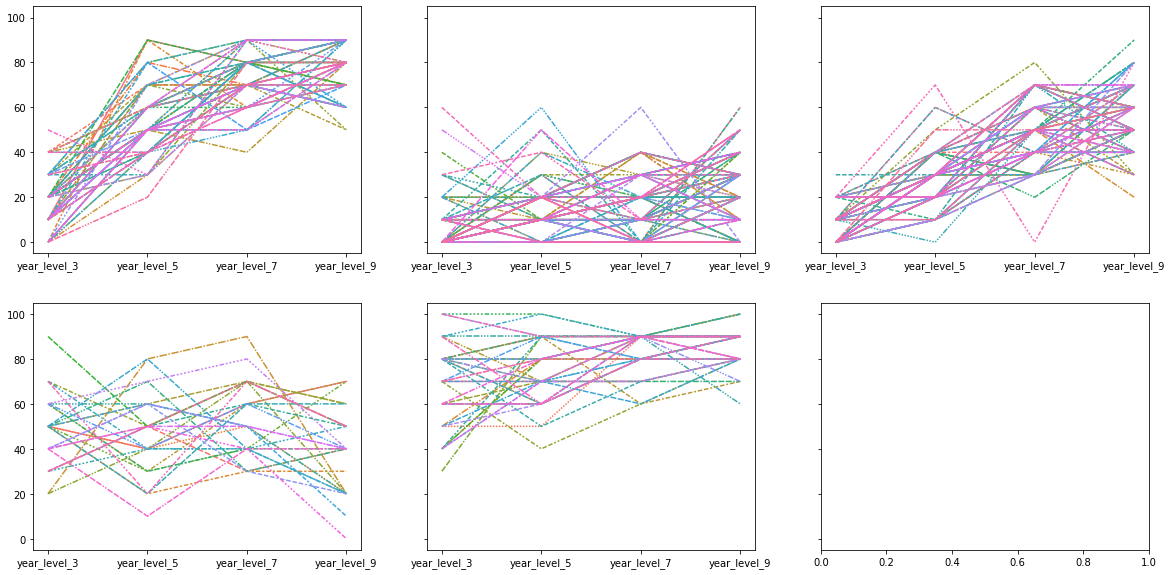

In [87]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit_transform(bins)
labels = kmeans.labels_

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 10), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])

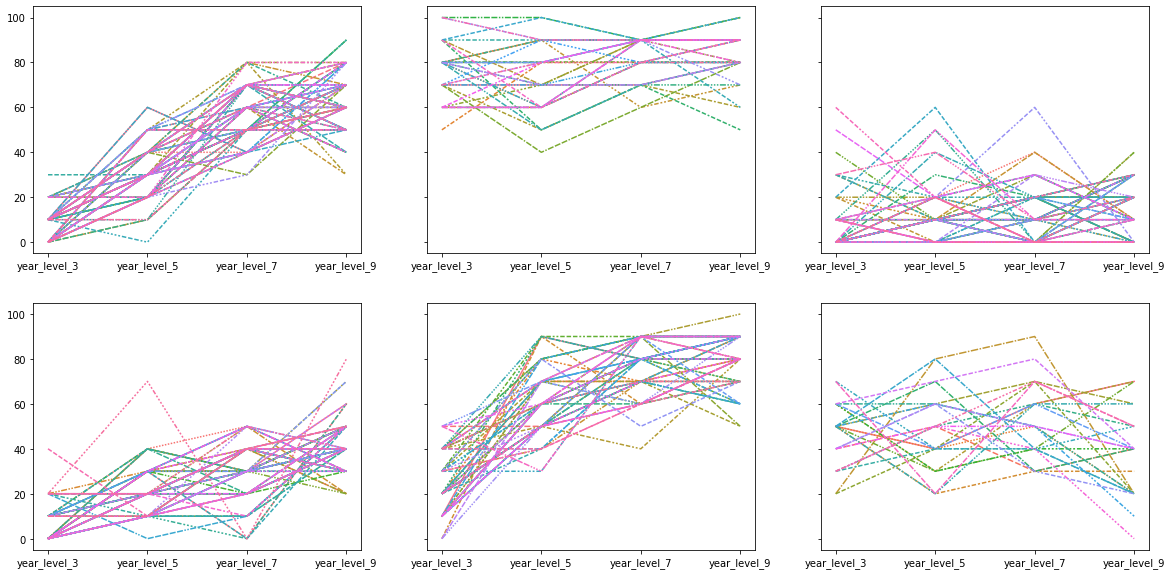

In [88]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit_transform(bins)
labels = kmeans.labels_

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 10), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])

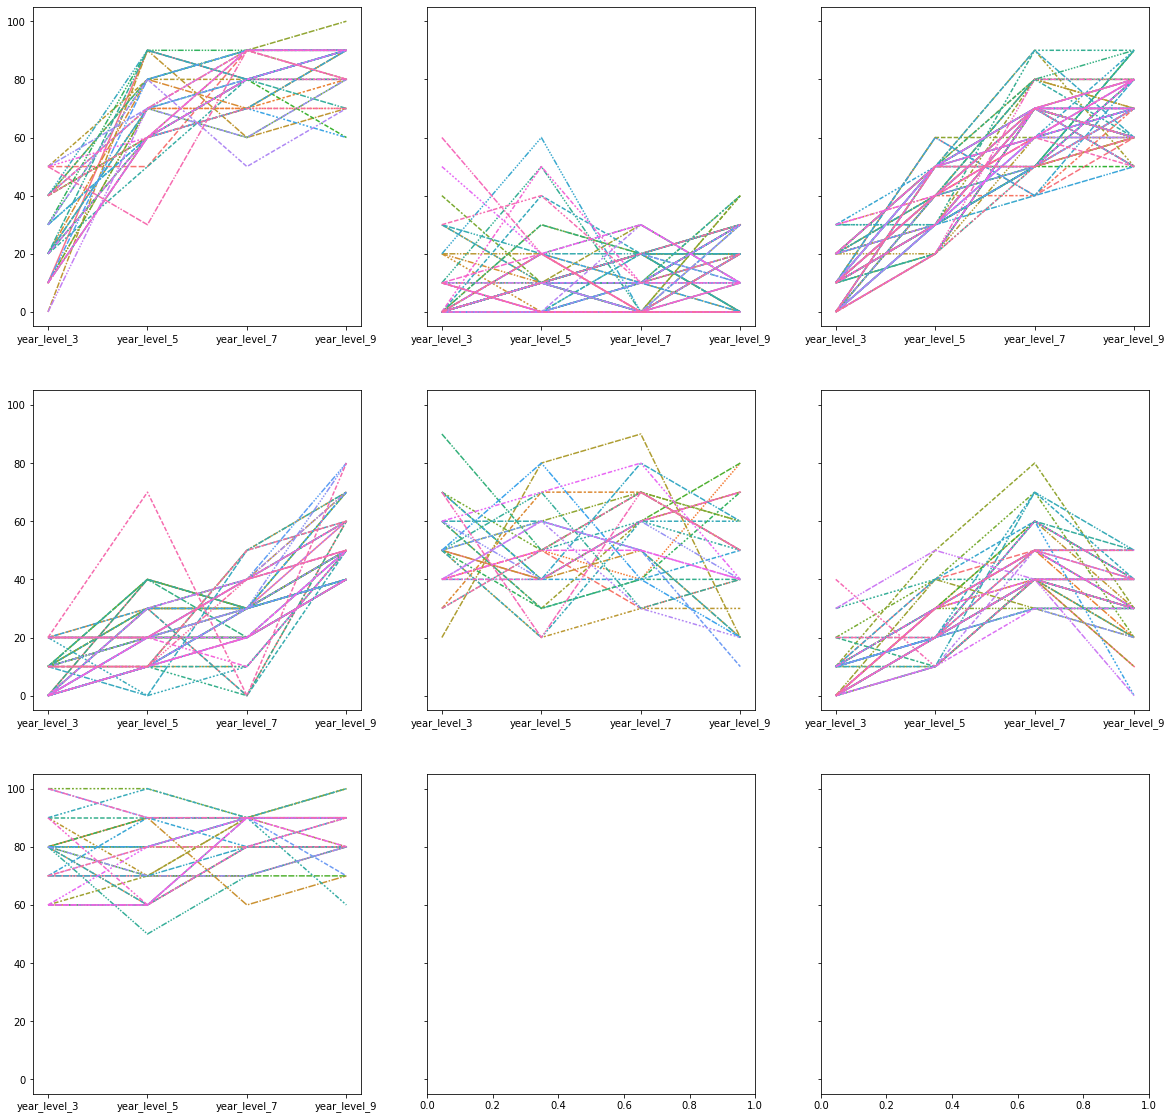

In [90]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit_transform(bins)
labels = kmeans.labels_

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 20), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])

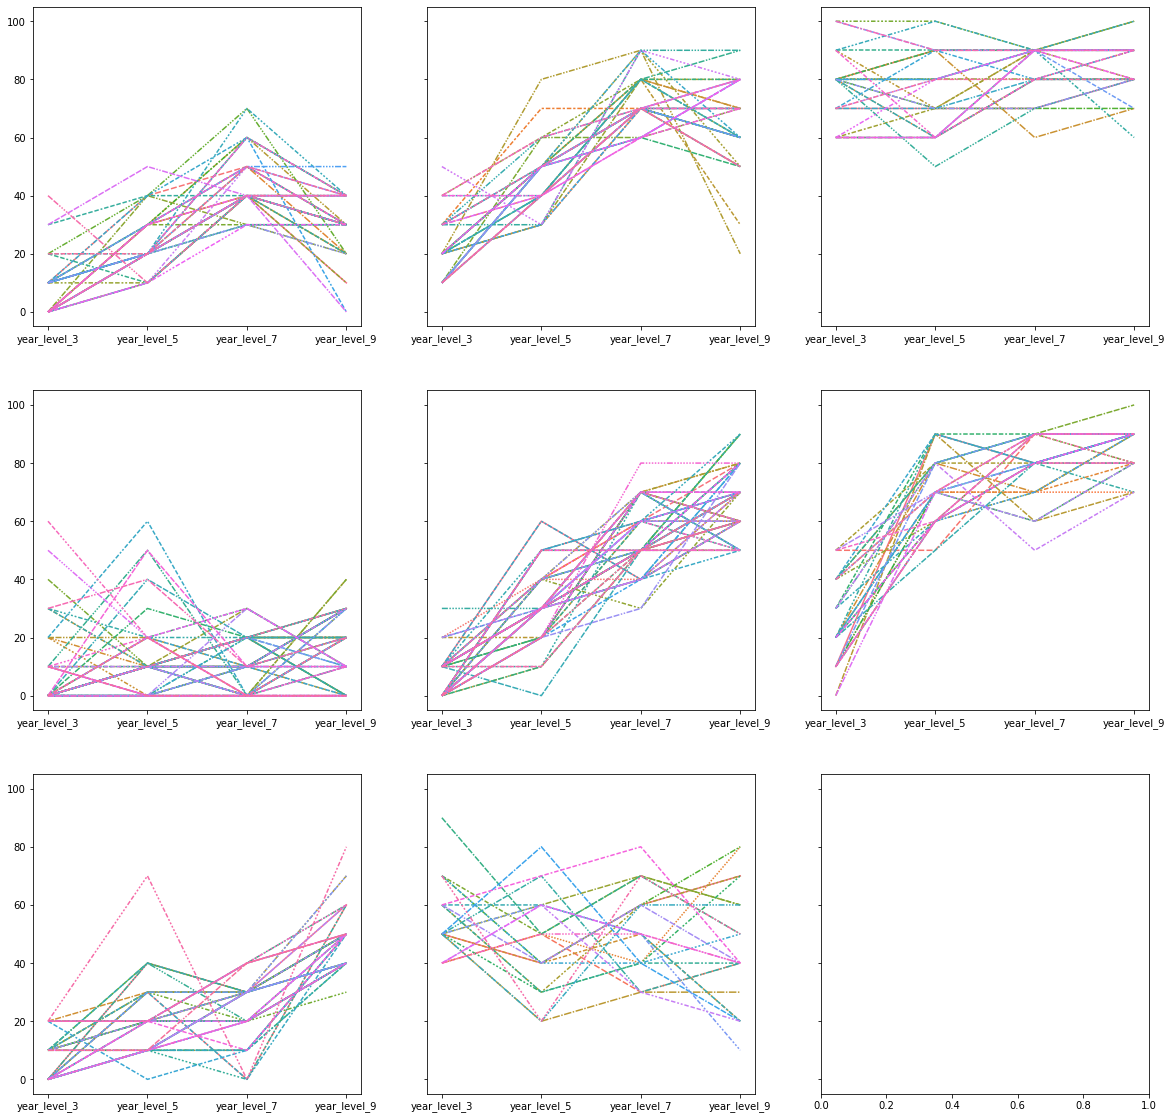

In [91]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit_transform(bins)
labels = kmeans.labels_

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 20), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])

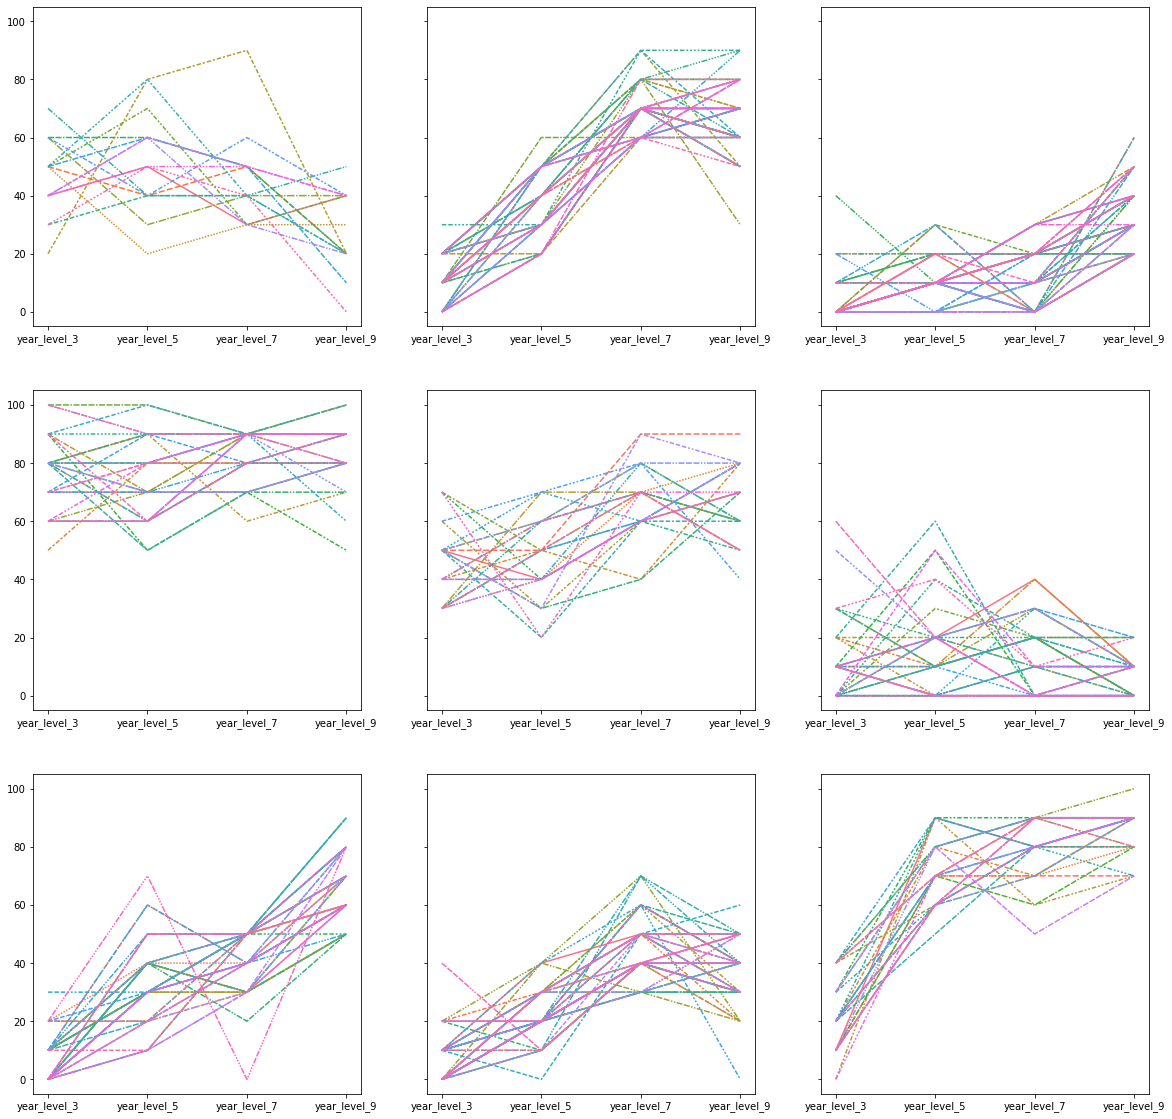

In [92]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit_transform(bins)
labels = kmeans.labels_

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 20), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])

In [101]:
max(labels)+1

9

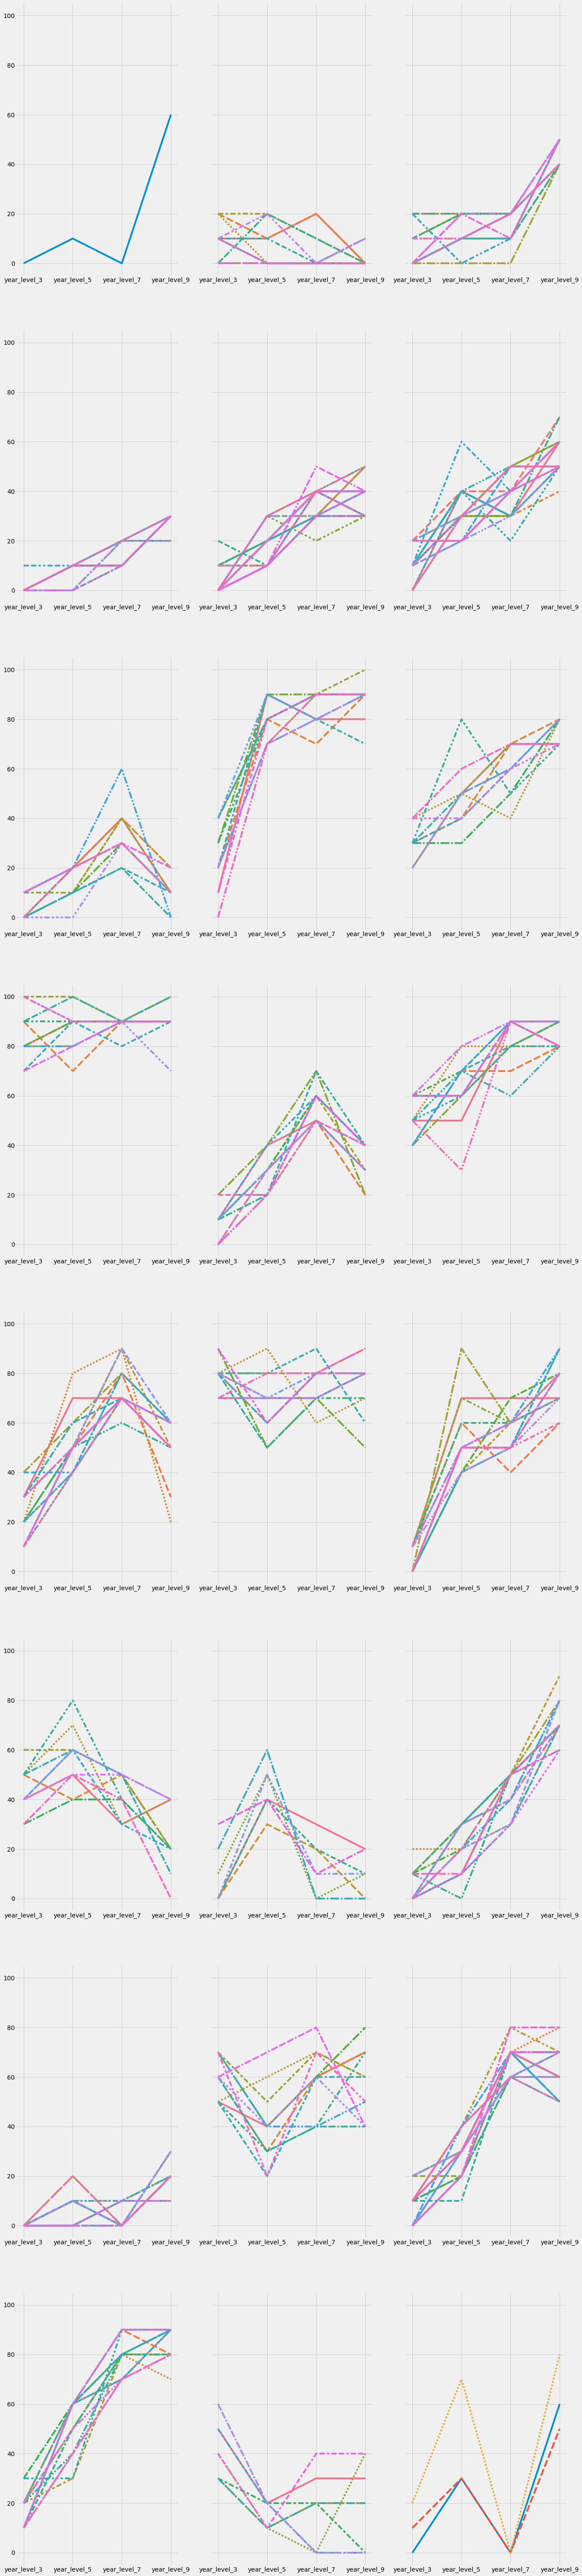

In [104]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=6, min_samples=2).fit(bins)
labels = kmeans.labels_
n_clusters = max(labels)+1

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 100), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])


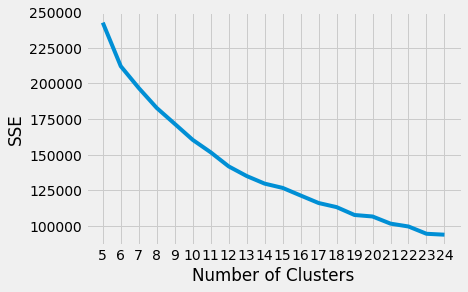

In [97]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(5, 25):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(bins)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(5, 25), sse)
plt.xticks(range(5, 25))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [108]:
!pip install plotly

You should consider upgrading via the 'c:\users\abhishek\azuredatastudio-python\python.exe -m pip install --upgrade pip' command.


In [109]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import plotly.express as px

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(bins)
distances, indices = nbrs.kneighbors(bins)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

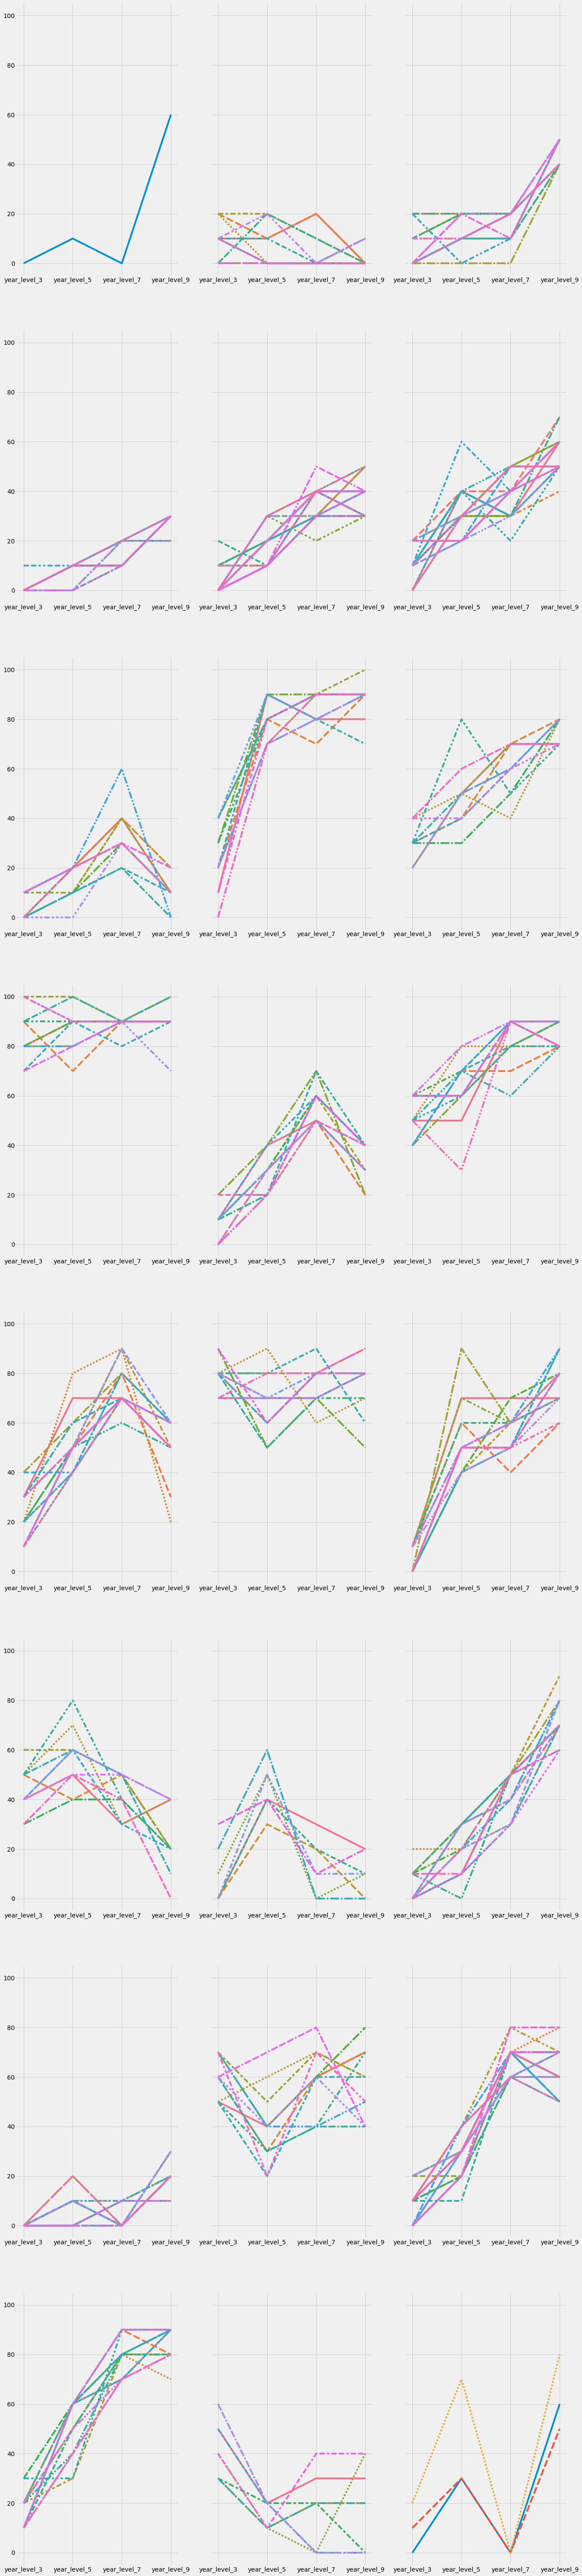

In [110]:
dbscan = DBSCAN(eps=14.14, min_samples=8).fit(bins)
labels = kmeans.labels_
n_clusters = max(labels)+1

fig, axs = plt.subplots(nrows=math.ceil(n_clusters/3), ncols=3, figsize=(20, 100), sharey=True)
for i in range(n_clusters):
    sns.lineplot(data=bins[labels==i].transpose(), legend=False, ax=axs[i//3, i%3])


In [114]:
# egg -> larva -> pupa -> butterfly -> super butterfly
cohort = [
    "can't comment",
    "egg",
    "egg-7-pupa",
    "egg-larva",
    "egg-pupaSmall ",
    "egg-pupa",
    "egg-pupa-7-egg",
    "larva-5-superButterfly",
    "larva-butterfly",
    "superButterfly",
    "egg-pupa-larva",
    "pupa-7-superButterfly",
    "larva_butterfly-7-pupa",
    "butterfly",
    "egg~butterfly",
    "larva-egg",
    "egg-pupa-5-egg",
    "egg-butterfly",
    "egg-larvaSmall",
    "pupa-pupa&butterfly",
    "egg-butterfly",
    "larva-7-superbutterfly",
    "pupa-larva",
    "wavy"
]

In [118]:
cluster_labels_df = pd.DataFrame({'cluster_number': np.arange(24), 'cluster_label': cohort})

stu_uuid
3ff47b1d-4af6-fbb9-f737-24e4cdfde53b    larva-5-superButterfly
e63781bb-e95f-3ef3-37d9-bd150aaf66ca       pupa-pupa&butterfly
3ff4ea15-a39c-27bf-ddfd-7005a295a475                 egg-larva
e637d8ac-e470-ccfc-de7b-a56c99625049                 butterfly
e63738af-de8e-a663-8125-8f6459a94441            superButterfly
                                                 ...          
3ff4e6e1-3776-2cf2-cb6e-1afca248b6ea    larva_butterfly-7-pupa
3ff48005-90e6-cab5-88a7-1139887c8cde    larva_butterfly-7-pupa
a307ddcb-9d1b-c195-3c2b-669844586fd9             egg-butterfly
3ff4085f-b783-b74c-58b9-1a5658fe0afc             egg~butterfly
d1f2b46d-3386-36d9-e582-87695252b2a7             egg-butterfly
Name: cluster_label, Length: 355, dtype: object

In [136]:
clustered_target_df = pd.concat([target_df, pd.Series(labels, index=target_df.index, name='cluster_number'), pd.Series(cluster_labels_df.loc[labels, 'cluster_label'].tolist(), index=target_df.index, name='cluster_label')], axis=1)

In [137]:
clustered_target_df.to_csv('clustered_target_df.csv')

In [140]:
fine_df['description']

0        NAPLAN Numeracy
1        NAPLAN Numeracy
2        NAPLAN Numeracy
3        NAPLAN Numeracy
4        NAPLAN Numeracy
              ...       
35167    NAPLAN Numeracy
35168    NAPLAN Numeracy
35169    NAPLAN Numeracy
35170    NAPLAN Numeracy
35171    NAPLAN Numeracy
Name: description, Length: 35172, dtype: object